In [3]:
import matplotlib.pyplot as plt

import torch
import urllib.request
import numpy as np

import flyvision

np.random.seed(42)


%load_ext autoreload
%autoreload 2

# Providing custom stimuli

This notebooks shows how to use the model as a ressource to test hypotheses based on custom stimuli.

## Example dataset

We take the public [Moving MNIST](https://www.cs.toronto.edu/~nitish/unsupervised_video/) sequence dataset as an example. It consists of short grey-scale videos of numbers from 1-10 which move in arbitrary directions. The dataset entails 10,000 sequences of 20 frames each. Individual frames are 64x64 pixels in height and width.

In [4]:
# path to public moving mnist mirror
moving_mnist_url = "https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy"

# path to where moving mnist will be stored for this example
moving_mnist_path = flyvision.root_dir / "mnist_test_seq.npy"

if not moving_mnist_path.exists():
    urllib.request.urlretrieve(moving_mnist_url, moving_mnist_path)

In [5]:
sequences = np.load(moving_mnist_path)  

In [6]:
# (n_frames, n_sequences, height, width)
sequences.shape

(20, 10000, 64, 64)

In [7]:
# transpose to (n_sequences, n_frames, height, width) and scale to [0, 1]
sequences = np.transpose(sequences, (1, 0, 2, 3)) / 255.

In [8]:
example_sequence_ids = np.random.randint(0, high=sequences.shape[0], size=10)

In [9]:
example_sequence_ids

array([7270,  860, 5390, 5191, 5734, 6265,  466, 4426, 5578, 8322])

<IPython.core.display.Javascript object>


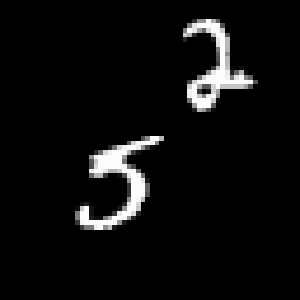

/home/lappalainenj@hhmi.org/flyvision_dmn/flyvision/animations/animations.py:74: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if samples != "all":


In [8]:
%matplotlib notebook
animation = flyvision.animations.Imshow(sequences, cmap=plt.cm.binary_r)
animation.notebook_animation(samples=example_sequence_ids)

## BoxEye rendering

##### Rendering cartesian images to hexagonal lattice

We translate cartesian frames into receptor activations by placing simulated photoreceptors in a two-dimensional hexagonal array in pixel space (blue dots below), 31 columns across resulting in 721 columns in total, spaced 13 pixels apart. The transduced luminance at each photoreceptor is the greyscale mean value in the 13×13-pixel region surrounding it (black boxes).

Note, inputs that require ultra-high spatial precision and correspondence to an LED-Arena can be rendered with the HexEye rendering class (coming soon!).

In [10]:
receptors = flyvision.rendering.BoxEye()

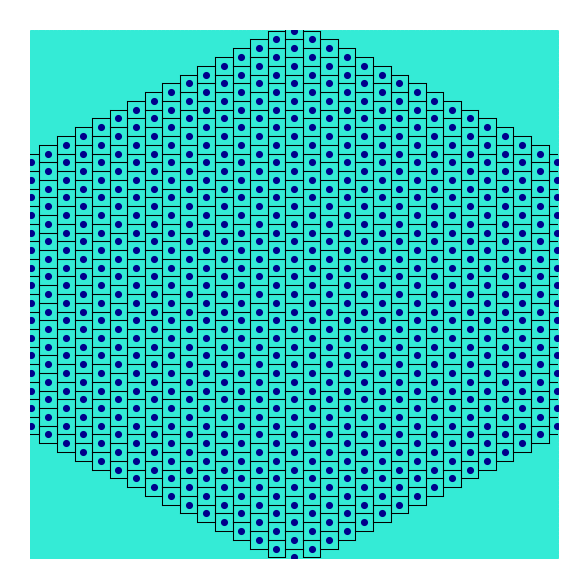

In [11]:
fig = receptors.illustrate()

### Render a single frame

To illustrate, this is what rendering a single frame looks like.

In [12]:
single_frame = sequences[0, 0]

<IPython.core.display.Javascript object>


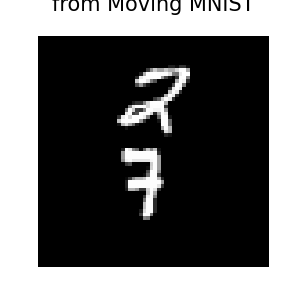

In [12]:
fig, ax = flyvision.plots.plt_utils.init_plot(figsize=[1, 1], fontsize=5)
ax.imshow(single_frame, cmap=plt.cm.binary_r)
ax = flyvision.plots.plt_utils.rm_spines(ax)
_ = ax.set_title('example frame \nfrom Moving MNIST', fontsize=5)

In [13]:
# the rendering uses pytorch native Conv2d module so it can be executed on GPU and fast
# we first move the frame to GPU
single_frame = torch.Tensor(single_frame).to("cuda")

In [14]:
single_frame.shape

torch.Size([64, 64])

In [15]:
# because the inputs to the receptors instance must have four dimensions (samples, frames, height, width),
# we create two empty dimensions for samples and frames
single_frame = single_frame[None, None]

In [16]:
# to render the single frame we simply call the instance
# this automatically rescales the frame to match the receptor layout as illustrated above
# and then places the average pixel value of the 13x13 boxes at the receptor positions
rendered = receptors(single_frame)

In [17]:
# the 721 receptor coordinates are implicitly given in the last dimension
# they correspond to sorted hexagonal coordinates (u-coordinate, v-coordinate, value)
rendered.shape

torch.Size([1, 1, 721])

<IPython.core.display.Javascript object>


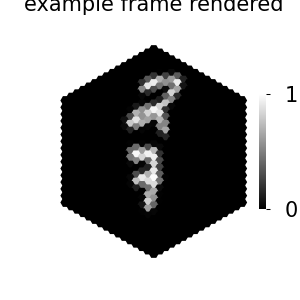

In [18]:
# the rendered frame is a slightly blurred version of the example
fig, ax, _ = flyvision.plots.plots.quick_hex_scatter(
    rendered.squeeze(), vmin=0, vmax=1, cbar_x_offset=0, fontsize=5
)
_ = ax.set_title("example frame rendered", fontsize=5)

In [19]:
# Disclaimer: thinking in hex coordinates can be unfamiliar.
# Therefore, we circumvent dealing with them explicitly.
# Still - to understand how the above plot infers the pixel-plane coordinates 
# from the implicit hexagonal coordinates, you can inspect the following code.

In [20]:
# # we can explicitly create sorted hex-coordinates from the integer radius of the hexagonal grid
# # for a regular hexagonal lattice, the radius is uniquely determined from the number of hexagons

# radius = flyvision.utils.hex_utils.get_hextent(rendered.shape[-1])

# # here we create integer u, v coordinates, and we stick to the same function and convention 
# # everywhere in the code
# u, v = flyvision.utils.hex_utils.get_hex_coords(radius)

# # we transform them to pixel coordinates using our convention
# x, y = flyvision.utils.hex_utils.hex_to_pixel(u, v)

# # and can just scatter them to be back at the photoreceptor layout
# fig, ax = flyvision.plots.plt_utils.init_plot(figsize=[2, 2], fontsize=5)
# ax.scatter(x, y, s=0.5)

## Render a whole dataset to disk

We save rendered sequences to disk to retrieve them faster at runtime.

We will use our library datamate here because it provides a powerful interface for writing and reading arrayfiles.

In [13]:
from os import PathLike
from datamate import root, Directory

In [14]:
# top-level directory to store the rendered data
rendered_data_dest = flyvision.root_dir / "custom_stimuli"

In [15]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

@root(rendered_data_dest) # to tell where the Directory-tree starts
class RenderedData(Directory):
    
    class Config(dict):
        path: PathLike
    
    def __init__(self, config: Config):
        
        # Here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # This code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = np.load(self.config.path)
        sequences = np.transpose(sequences, (1, 0, 2, 3)) / 255.
        receptors = flyvision.rendering.BoxEye()
        
        rendered_sequences = []
        for sequence in sequences:
            rendered_sequences.append(boxeye(sequence[None]).cpu().numpy())
        
        # datamate works best with numpy arrays
        rendered_sequences = np.array(rendered_sequences)    
                    
        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences
        self.sequences = rendered_sequences 

In [16]:
moving_mnist_rendered = RenderedData(dict(path=moving_mnist_path))

In [17]:
# this is how we can retrieve the sequences from the disk into memory
rendered_sequences = moving_mnist_rendered.sequences[:]

In [18]:
rendered_sequences.shape

(10000, 1, 20, 721)

In [19]:
# to stick to our convention for dimensions (samples, frames, 1, hexals)
rendered_sequences = np.transpose(rendered_sequences, (0, 2, 1, 3))

<IPython.core.display.Javascript object>


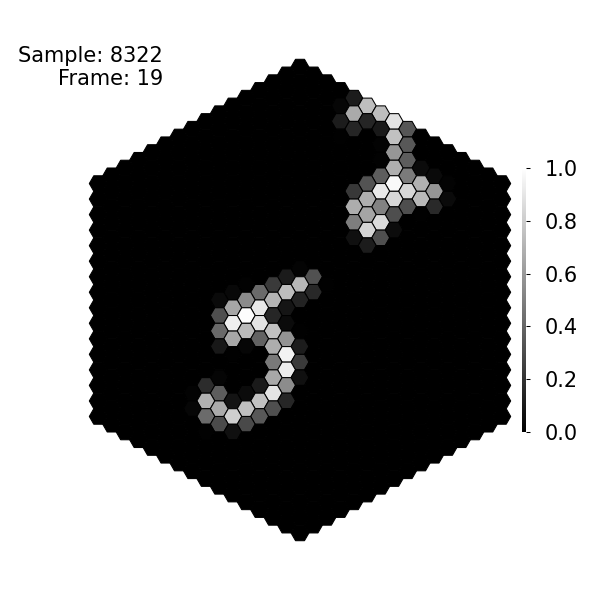

/home/lappalainenj@hhmi.org/flyvision_dmn/flyvision/animations/hexscatter.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


In [28]:
%matplotlib notebook
animation = flyvision.animations.HexScatter(rendered_sequences, vmin=0, vmax=1)
animation.notebook_animation(samples=example_sequence_ids)

In [29]:
# Note, to delete a Directory, eg because you want to change the preprocessing but not the config,
# run moving_mnist_rendered.rmtree("y").

## Create a sequence dataset

We create a generic interface for custom datasets to make dataloading consistent---this interface can tell the sampler what the framerate, the integration time steps, durations for pre-, and post grey-scale stimulation, and the number of sequences are.

In this case, we inherit a SequenceDataset, that also obeys (and extends) the interface of Pytorch's Dataset.

In [20]:
from flyvision.datasets.base import SequenceDataset


class CustomStimuli(SequenceDataset):
    
    dt = 1/50
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, path):
        self.dir = RenderedData(dict(path=path))
        self.sequences = torch.permute(torch.Tensor(self.dir.sequences[:]), (0, 2, 1, 3))
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [21]:
data = CustomStimuli(moving_mnist_path)

In [22]:
data[0].shape

torch.Size([42, 1, 721])

<IPython.core.display.Javascript object>


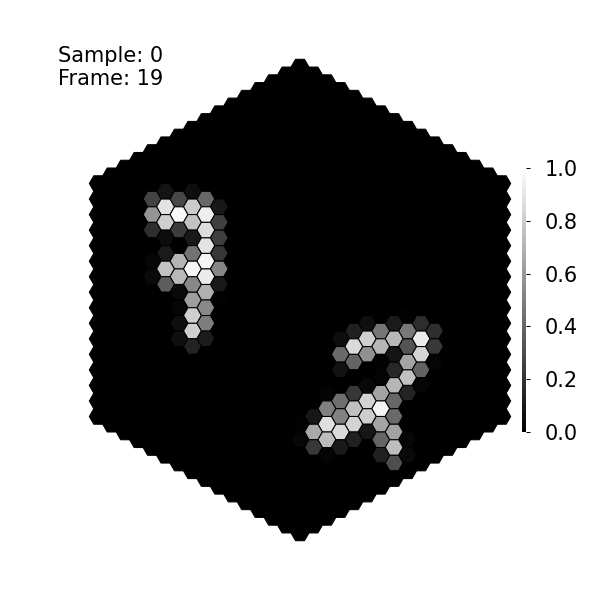

/home/lappalainenj@hhmi.org/flyvision_dmn/flyvision/animations/hexscatter.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


In [43]:
%matplotlib notebook
animation = flyvision.animations.HexScatter(data[0][None], vmin=0, vmax=1)
animation.notebook_animation()

## Compute model responses to custom stimuli

In [23]:
from flyvision.ensemble import EnsembleDir, Ensemble, EnsembleView
from flyvision.utils.activity_utils import LayerActivity

In [24]:
ensemble = EnsembleView(flyvision.results_dir / "opticflow/000")

In [25]:
movie_input = data[0]

In [41]:
# ensemble.simulate returns an iterator over responses of networks from the ensemble
# to exhaust it and stack responses from all models in the first dimension
responses = np.array(list(ensemble.simulate(movie_input[None], 1/50)))

In [38]:
# the dimensions are (number of models, number of samples, number of frames, number of cells)
responses.shape

(50, 1, 20, 45669)

In [42]:
# to make inspection of single-cell type responses feasible, we need the explicit reference to the connectome
voltages = LayerActivity(responses, ensemble[0].ctome, keepref=True)

In [49]:
voltages[cell_type]

(50, 1, 20, 721)

<IPython.core.display.Javascript object>


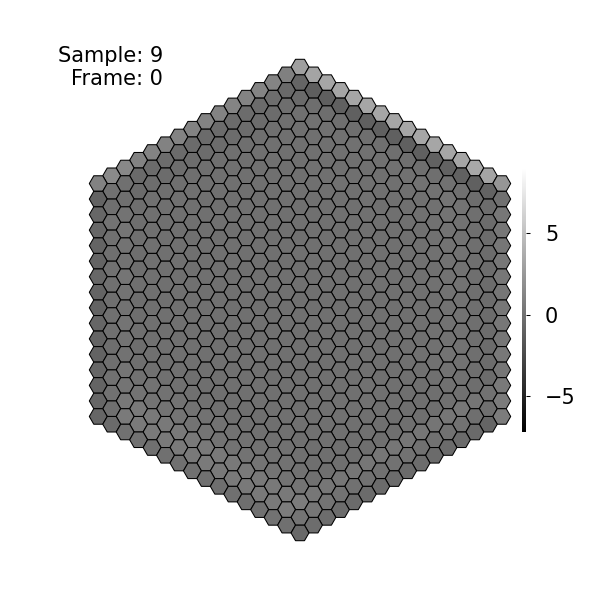

/home/lappalainenj@hhmi.org/flyvision_dmn/flyvision/animations/hexscatter.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


In [50]:
# to look at how a specific cell type responds in the models

cell_type = "T4c"

anim = flyvision.animations.HexScatter(voltages[cell_type].squeeze()[:, :, None])
anim.notebook_animation()

In [32]:
# we know that one set of models is upwards tuning for T4c and one is downwards tuning 
# -- lets find out if we can observe that
cluster_indices = ensemble.cluster_indices("T4c")

<IPython.core.display.Javascript object>


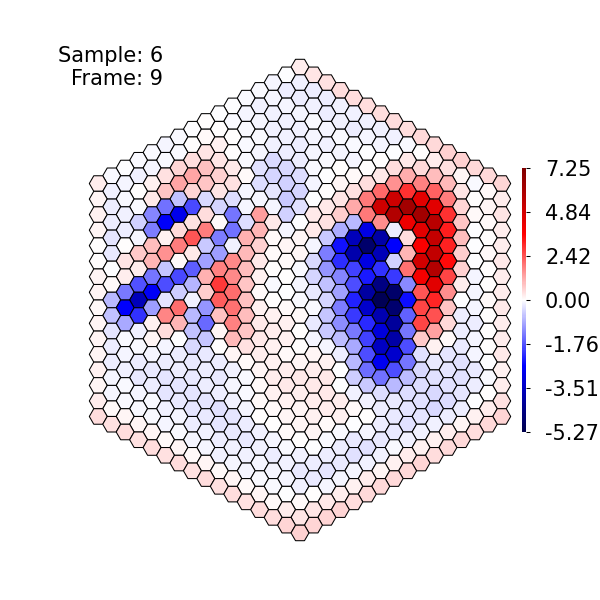

In [53]:
# in this cluster of models, T4c should be tuning to upwards ON-motion

cell_type = "T4c"

anim = flyvision.animations.HexScatter(
    voltages[cell_type].squeeze()[:, :, None], cmap=plt.cm.seismic, midpoint=0
)
anim.notebook_animation(samples=cluster_indices[0])

<IPython.core.display.Javascript object>


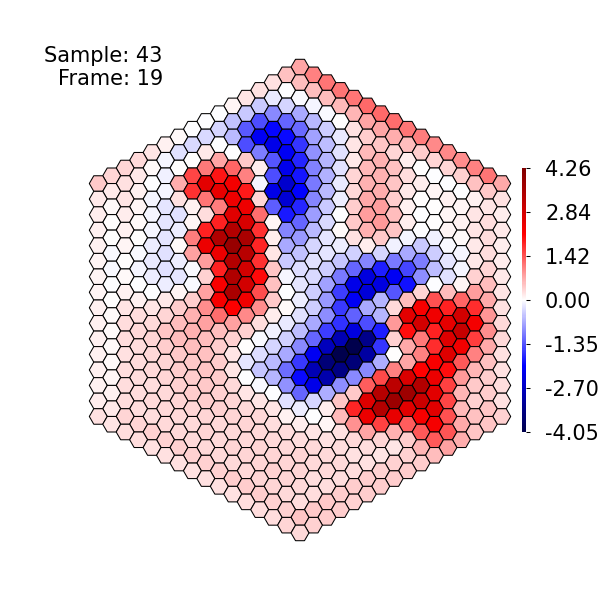

In [56]:
# in this cluster of models, T4c should be tuning to downwards ON-motion

cell_type = "T4c"

anim = flyvision.animations.HexScatter(
    voltages[cell_type].squeeze()[:, :, None], cmap=plt.cm.seismic, midpoint=0
)
anim.notebook_animation(samples=cluster_indices[1])

In [43]:
# often, we are interested in the response of a single-cell from a specific type.
# in our model, we can take the central cell as a proxy for all cells of the given type.
# because we use average filters, i.e. we could assume perfect convolutional structure of the system 
# to build our model. 
# the function of the surrounding cells of a given type resembles the function of the central cell
# of the type
central_voltages = voltages.central

<IPython.core.display.Javascript object>


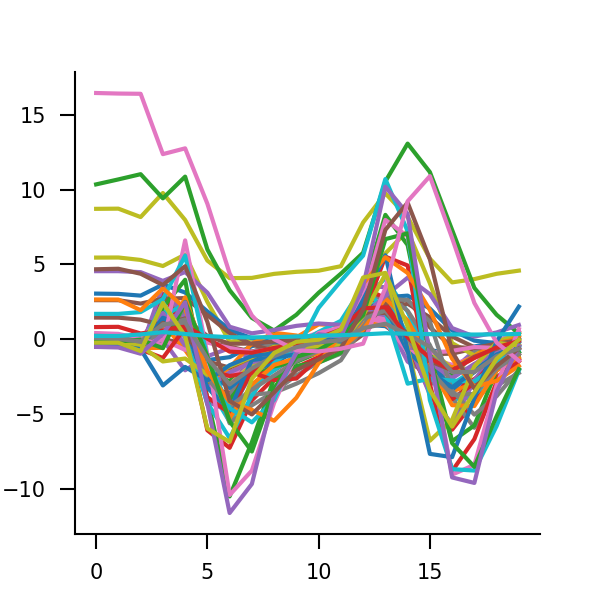

In [77]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
_ = ax.plot(central_voltages[cell_type].squeeze().T)

<IPython.core.display.Javascript object>


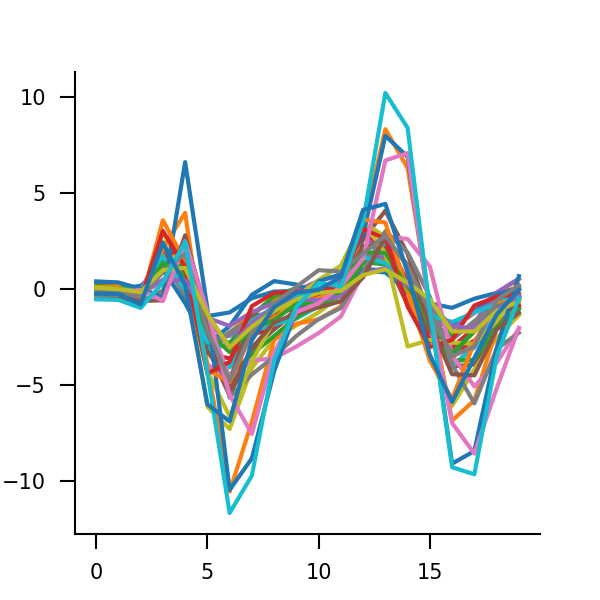

In [74]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
_ = ax.plot(central_voltages[cell_type].squeeze().T[:, cluster_indices[0]])

<IPython.core.display.Javascript object>


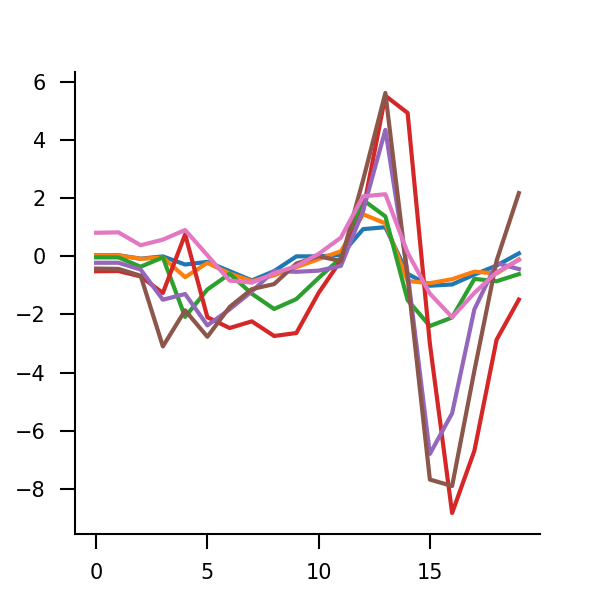

In [75]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
_ = ax.plot(central_voltages[cell_type].squeeze().T[:, cluster_indices[1]])

<IPython.core.display.Javascript object>


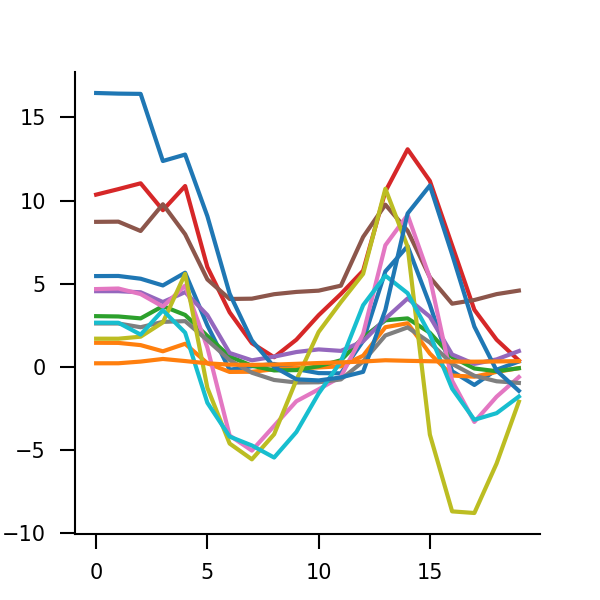

In [76]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
_ = ax.plot(central_voltages[cell_type].squeeze().T[:, cluster_indices[2]])

## To go full circle, let's decode motion and report motion selectivity from the models

In [75]:
movie_inputs = torch.stack([data[_id] for _id in example_sequence_ids])

In [82]:
responses = np.array(list(ensemble.simulate(movie_inputs, 1/50)))

In [76]:
decoded = np.array(list(ensemble.decode(movie_inputs, 1/50)))

In [77]:
decoded.shape

(50, 10, 42, 2, 721)

In [202]:
# let's take the best-10-model average to get an estimate of motion direction
# at the central receptor.
# note that the central receptor is at index 360
motion_estimate = 1/weights.sum() * (weights[:, None, None, None] * decoded[:, :, :, :, 360]).sum(axis=0)

In [204]:
motion_angle = np.arctan2(motion_estimate[:, :, 1], motion_estimate[:, :, 0])

In [40]:
# now, let's get the responses of the central T4c cell in the best model

In [83]:
voltages = LayerActivity(responses, ensemble[0].ctome, keepref=True)
central_voltages = voltages.central

In [221]:
central = central_voltages["T4c"]

In [222]:
r = np.maximum(central[0], 0)

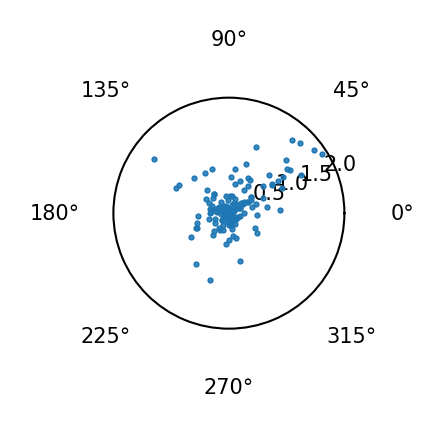

In [223]:
fig, ax = flyvision.plots.plt_utils.init_plot(projection="polar", fontsize=5)
ax.plot(motion_angle.flatten(), r.flatten(), ".")
ax.grid(False)

In [224]:
np.degrees(np.angle((r * np.exp(motion_angle * 1j)).sum()))

56.43227811329988

In [225]:
np.abs((r * np.exp(motion_angle * 1j)).sum()) / r.sum()

0.33238244194106376

In [230]:
flow = decoded[:45].mean(axis=0)

In [267]:
from flyvision.animations.hexflow import HexFlow
from flyvision.animations.hexscatter import HexScatter

In [250]:
from flyvision.animations.animations import AnimationCollector

In [241]:
Animation??

In [270]:
class InputFlow(AnimationCollector):
    
    def __init__(self, movie_input, optic_flow):
        self.frames, self.n_samples = movie_input.shape[:2]
        update = True
        self.batch_sample = 0
        self.fig, self.axes = plt.subplots(1, 2, figsize=[4, 2])
        self.animations.append(HexScatter(movie_input, vmin=0, vmax=1, fig=self.fig, ax=self.axes[0]))
        self.animations.append(HexFlow(optic_flow, fig=self.fig, ax=self.axes[1]))

<IPython.core.display.Javascript object>


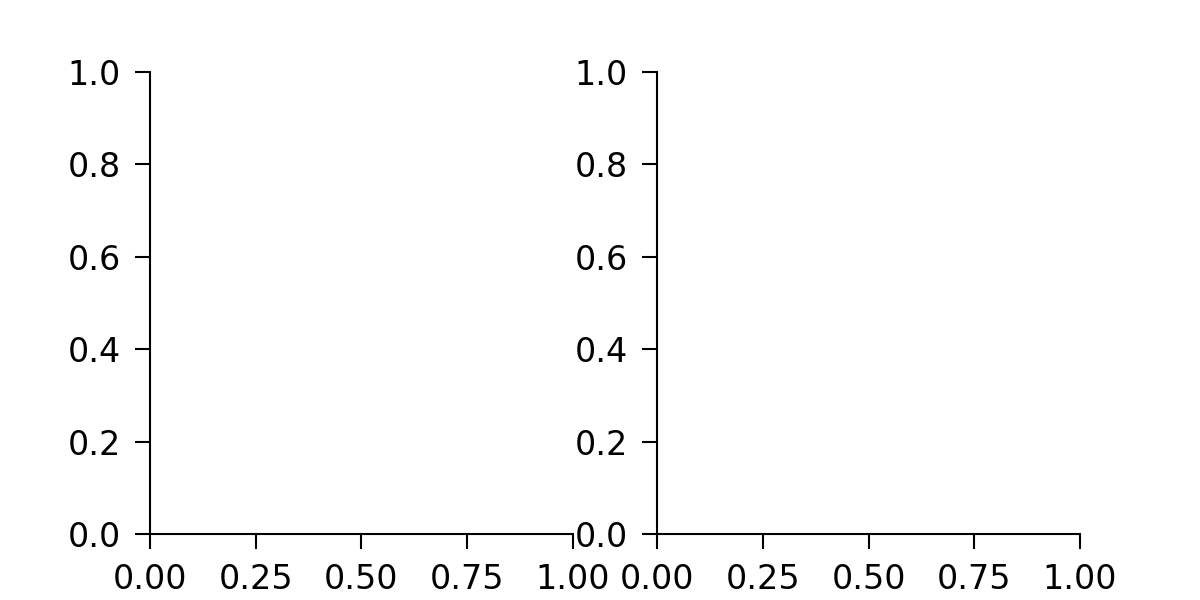

AttributeError: 'HexFlow' object has no attribute 'figsize'

In [271]:
%matplotlib notebook
animation = InputFlow2(movie_inputs, flow)
animation.notebook_animation()

<IPython.core.display.Javascript object>


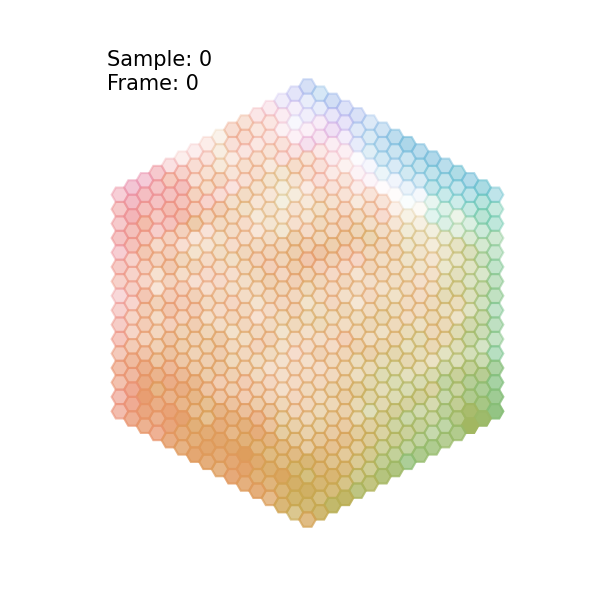

In [264]:
HexFlow(flow).init()